In [2]:
import sys
from pathlib import Path

sys.path.insert(0, str(Path.cwd().parent))

In [3]:
#Imports и проверка окружения
import numpy as np
import torch
import matplotlib.pyplot as plt

from data.synthetic import make_moons_dataset, split_and_standardize
from models.mlp import MLP
from optim.factory import OptimConfig, make_optimizer
from train.trainer import TrainConfig, train_classifier

torch.manual_seed(42)
np.random.seed(42)


In [4]:
#Данные: moons, split, StandardScaler
device = "cpu"  

X, y = make_moons_dataset(n_samples=4000, noise=0.25, seed=42, device=device)
X_tr, y_tr, X_val, y_val, scaler = split_and_standardize(X, y, test_size=0.2, seed=42)

print(X_tr.shape, y_tr.shape, X_val.shape, y_val.shape)


torch.Size([3200, 2]) torch.Size([3200]) torch.Size([800, 2]) torch.Size([800])


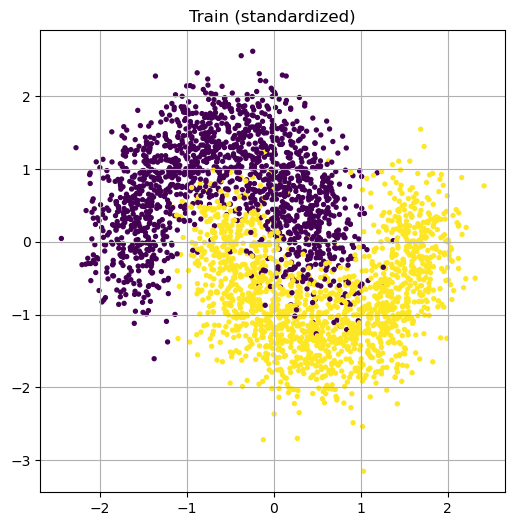

In [5]:
#(Опционально) визуализация train
plt.figure(figsize=(6,6))
plt.scatter(X_tr[:,0].cpu(), X_tr[:,1].cpu(), c=y_tr.cpu(), s=8)
plt.title("Train (standardized)")
plt.grid(True)
plt.show()


In [6]:
#Утилита для графиков
def plot_history(hist, title=""):
    steps = hist["step"]

    plt.figure(figsize=(10,4))
    plt.plot(steps, hist["train.loss"], label="train.loss")
    plt.plot(steps, hist["val.loss"], label="val.loss")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.title(title + " | loss")
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(steps, hist["train.acc"], label="train.acc")
    plt.plot(steps, hist["val.acc"], label="val.acc")
    plt.grid(True)
    plt.legend()
    plt.title(title + " | accuracy")
    plt.show()

    plt.figure(figsize=(10,4))
    plt.plot(steps, hist["grad.global"], label="grad.global")
    plt.plot(steps, hist["update.global"], label="update.global")
    plt.plot(steps, hist["param.global"], label="param.global")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.title(title + " | norms")
    plt.show()

    # эффективный "шаг" на единицу градиента
    eff = np.array(hist["update.global"]) / (np.array(hist["grad.global"]) + 1e-12)
    plt.figure(figsize=(10,4))
    plt.plot(steps, eff, label="update/grad")
    plt.yscale("log")
    plt.grid(True)
    plt.legend()
    plt.title(title + " | effective step (update/grad)")
    plt.show()


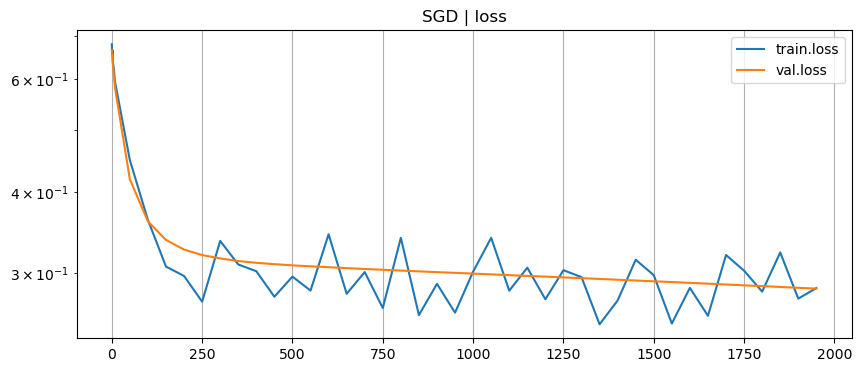

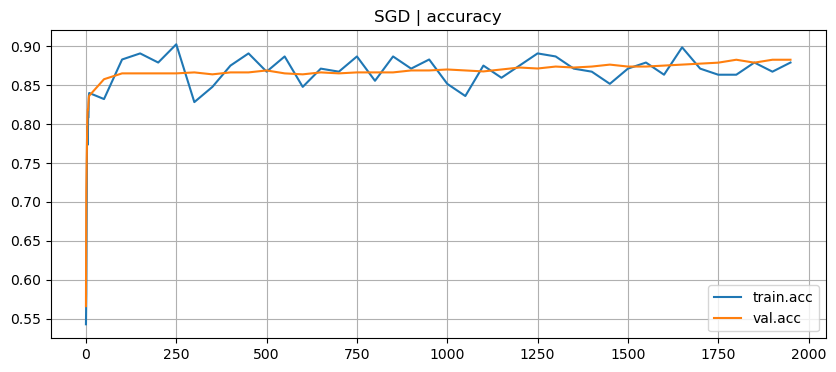

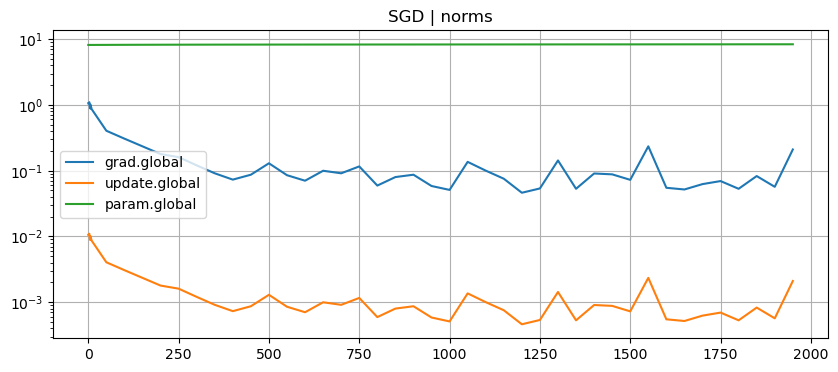

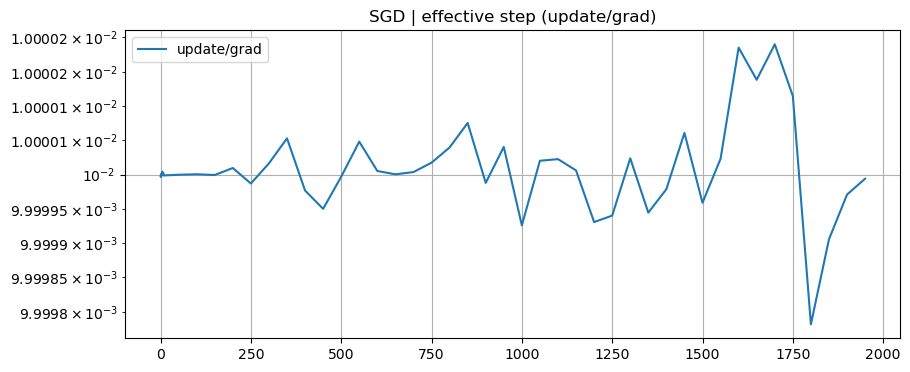

In [7]:
#Прогон SGD
model_sgd = MLP(in_dim=2, hidden_dim=128, out_dim=1, act="relu", use_he=True)

opt_cfg = OptimConfig(name="sgd", lr=1e-2, weight_decay=0.0)
opt_sgd = make_optimizer(model_sgd.parameters(), opt_cfg)

cfg = TrainConfig(
    steps=2000,
    batch_size=256,
    log_every=50,
    clip_norm=None,
    device=device,
)

hist_sgd = train_classifier(
    model=model_sgd,
    optimizer=opt_sgd,
    X_train=X_tr,
    y_train=y_tr,
    X_val=X_val,
    y_val=y_val,
    cfg=cfg,
)

plot_history(hist_sgd, "SGD")


*SGD|norms:*
- param.global (зелёный) -- почти константа, около ~10 --> веса не “раздуваются” по норме
- update.global (оранжевый) -- около 1e-2, потом уменьшается к ~1e-3 --> update пропорционален grad: когда grad уменьшается, update тоже уменьшается

*SGD|effective step:*
- кривая держится около 1e-2 практически постоянно --> update/grad действительно измеряет эффективный коэффициент преобразования градиента в апдейт, и для SGD он стабилен и равен learning rate

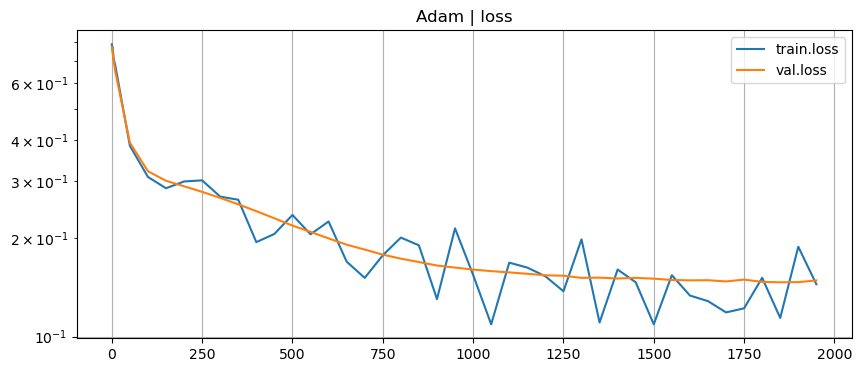

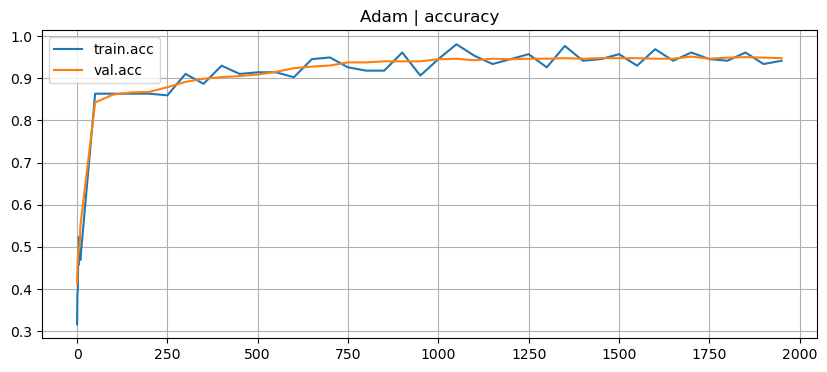

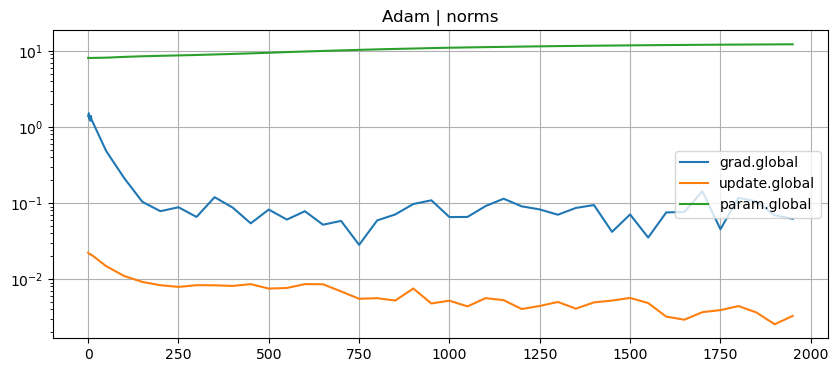

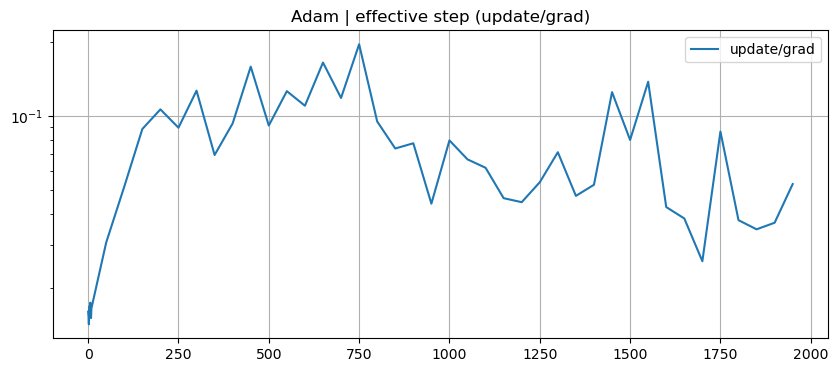

In [9]:
#Прогон Adam
model_adam = MLP(in_dim=2, hidden_dim=128, out_dim=1, act="relu", use_he=True)

opt_cfg = OptimConfig(name="adam", lr=1e-3, weight_decay=0.0)
opt_adam = make_optimizer(model_adam.parameters(), opt_cfg)

hist_adam = train_classifier(
    model=model_adam,
    optimizer=opt_adam,
    X_train=X_tr,
    y_train=y_tr,
    X_val=X_val,
    y_val=y_val,
    cfg=cfg,
)

plot_history(hist_adam, "Adam")


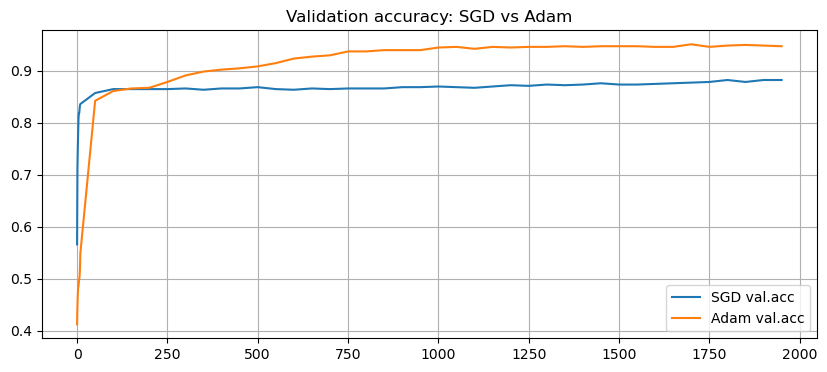

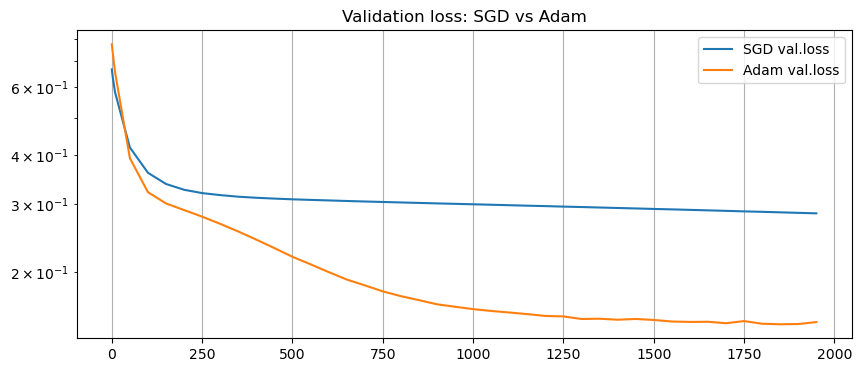

In [10]:
#Сравнение на одном графике
plt.figure(figsize=(10,4))
plt.plot(hist_sgd["step"], hist_sgd["val.acc"], label="SGD val.acc")
plt.plot(hist_adam["step"], hist_adam["val.acc"], label="Adam val.acc")
plt.grid(True)
plt.legend()
plt.title("Validation accuracy: SGD vs Adam")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(hist_sgd["step"], hist_sgd["val.loss"], label="SGD val.loss")
plt.plot(hist_adam["step"], hist_adam["val.loss"], label="Adam val.loss")
plt.yscale("log")
plt.grid(True)
plt.legend()
plt.title("Validation loss: SGD vs Adam")
plt.show()


В эксперименте на бинарной классификации make_moons(noise=0.25) Adam демонстрирует более быструю и глубокую сходимость по сравнению с SGD.
Анализ логов показывает, что для SGD эффективный шаг обновления параметров остаётся практически постоянным и равным learning rate, в то время как для Adam этот шаг существенно выше и адаптивно меняется во времени.
Это позволяет Adam продолжать оптимизацию функции потерь даже после того, как SGD выходит на плато, что приводит к более низкому validation loss и более высокой validation accuracy.